In [31]:
# load required library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
import datetime

In [145]:
air_quality = pd.read_csv('AirQualityUCI_req.csv')
air_quality['text_number'] = '3' 
air_quality.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,text_number
0,10/03/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,3
1,10/03/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,3
2,10/03/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,3
3,10/03/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,3
4,10/03/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,3


# Project Outline

## Descriptive Statistics

### Overview of the Dataset

1. Number of variables

2. Number of observations

3. Memory usage

## Missing Values

1. Visualize missing values using heatmap

2. Suggestions for handling missing value

## Variable Types

1. Print out current data types from Pandas

2. Type conversion suggestions: 

 * String datetime -> datetime
 
 * Small interger (for example: boolean)  -> categorical type
 
 * String float -> float
 
 * Maximum cardinality (number of unique == number of observations) -> remove

## Visualization

In [146]:
def datetime_validate(text):
    matched_format = 0
    for date_format in ['%Y-%m-%d', '%Y/%m/%d', '%m/%d/%Y', '%m-%d-%Y','%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S.%f', '%H:%M:%S', '%H:%M']:
        try:
            datetime.datetime.strptime(text, date_format)
            matched_format += 1
        except ValueError:
            pass
    return matched_format > 0

def numeric_validate(text):
    return text.replace('.','',1).replace('-','',1).isdigit()

In [163]:
NUMERICS_TYPES = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
CATEGORICAL_TYPES = ['object', 'category']

class auto_eda():
    def __init__(self, df):
        self.df = df.copy()
        self.num_variables = self.df.shape[0]
        self.num_obs = self.df.shape[1]
        self.memory_usage = str(self.df.memory_usage(deep=True).sum() / 1000000) + ' Mb' # memory in mb
        self.numric_cols = self.df.select_dtypes(include = NUMERICS_TYPES).columns.tolist()
        self.cat_cols = self.df.select_dtypes(include = CATEGORICAL_TYPES).columns.tolist()
        self.other_cols = self.df.select_dtypes(exclude = NUMERICS_TYPES + CATEGORICAL_TYPES).columns.tolist()
        
        
    def get_overview(self):
        overview = {}
        overview['Number of Variables:'] = self.num_variables
        overview['Number of Observations:'] = self.num_obs
        overview['Memory Usage:'] = self.memory_usage
        for k,v in overview.items():
            print(k,v)
    
    def get_missings(self, missing_tag = None):
        '''
        Sometimes missing values are denoted with a number or string, 
        enter the missing tag to replace them with NAs
        '''
        if missing_tag is not None:
            self.df.replace(missing_tag, np.nan, inplace = True)
        
        # check if there are any null values
        if self.df.isnull().sum().sum() == 0:
            print('''There is no missing value, please check if the missings have been encoded with non-NAN value.
Use argument missing_tag for encoded missing values''')
        else:
            # missing heatmap display the missing values position in the dataset
            missing_heatmap = plt.figure(1)
            msno.matrix(self.df)
            plt.title('Missing Values shown in White',fontsize=25)

            # correlation plot: how strongly the presence or absence of one variable affects the presence of another
            correlation_plot = plt.figure(2)
            msno.heatmap(self.df,cbar= False)
            plt.title('Missing Values Correlation',fontsize=25)

            # The dendrogram uses a hierarchical clustering algorithm 
            # to bin variables against one another by their missing values correlation 
            missing_dendogram = plt.figure(3)
            msno.dendrogram(self.df)
            plt.title('Missing Values Dendrogram',fontsize=25)
        
    def handle_missings(self, strategy = None):
        '''
        PLEASE RUN get_missings() FIRST TO IDENTIFY MISSINGS.
        
        Handling missing values strategies:
        
        deletion: drop variables with > 70% missing and
        remove observations that contain at least 1 missing value.
        
        encode (Encoding imputation): for numerical variable, encoding missing entries as -999. 
        For categorical variable, encoding missing entries as string "unknown"
        
        mean_mode (Mean/mode imputation): for numerial variable, impute the missing entries with the mean, 
        For categorical variable, impute the missing entries with the mode
        
        '''
        strategies = ['deletion', 'encode', 'mean_mode']
        if self.df.isnull().sum().sum() == 0:
            print('There is no missing value in the dataset')
        elif strategy not in strategies:
            print('No strategy selected, please specify one of the following deletion, encode, or mean_mode')
        else:
            if strategy == 'deletion':
                # drop variable with > 70% missing
                percent_missing = self.df.isnull().sum() * 100 / len(self.df)
                drop_list = percent_missing[percent_missing > 70].index.tolist()
                self.df.drop(drop_list, axis = 1, inplace = True) 
                
                # drop row contains 1 or more missing values
                drop_row_count = self.df.shape[0] - self.df.dropna().shape[0]
                rows_percentage = round(drop_row_count / self.df.shape[0] * 100, 1)
                self.df.dropna(inplace=True)
                
                print('Dropped columns: {}\nNumber of dropped rows: {} --> {}% of rows removed'.format(drop_list, drop_row_count, rows_percentage))
            
            elif strategy == 'encode':
                # encoding missing numerics as -999, categories as 'unknown'
                numerics_replaced = (len(self.df[self.numric_cols]) - self.df[self.numric_cols].count()).sum()
                self.df[self.numric_cols] = self.df[self.numric_cols].fillna(-999)
                
                cats_replaced = (len(self.df[self.cat_cols]) - self.df[self.cat_cols].count()).sum()
                self.df[self.cat_cols] = self.df[self.cat_cols].fillna('unknown')
                
                print('Count of encoded numerical values: {}\nCount of encoded categorical values: {}'.format(numerics_replaced, cats_replaced))
                
            elif strategy == 'mean_mode':
                # impute missing numerics with mean value
                numerics_replaced = (len(self.df[self.numric_cols]) - self.df[self.numric_cols].count()).sum()
                self.df[self.numric_cols] = self.df[self.numric_cols].fillna(self.df[self.numric_cols].mean())
                
                # impute missing categories with mode value
                cats_replaced = (len(self.df[self.cat_cols]) - self.df[self.cat_cols].count()).sum()
                self.df[self.cat_cols] = self.df[self.cat_cols].fillna(self.df[self.cat_cols].mode().iloc[0])
                
                print('Count of imputed numerical values: {}\nCount of imputed categorical values: {}'.format(numerics_replaced, cats_replaced))
    
    def check_data_type(self):
        column_series = self.df.dtypes.index
        type_series = self.df.dtypes.values
        cardinality = self.df.apply(pd.Series.nunique)
        
        frame = {'Column': column_series, 'Type': type_series, 'Cardinality': cardinality }
        data_types = pd.DataFrame(frame).reset_index(drop=True)
                
        high_cardinality_condition = (data_types['Type'].isin(CATEGORICAL_TYPES)) & (data_types['Cardinality'] > len(self.df)/2)
        low_cardinality_condition = (data_types['Type'].isin(NUMERICS_TYPES)) & (data_types['Cardinality'] < 20)
        
        # check cardinality
        data_types['Warning'] = np.where(high_cardinality_condition, 'high_cardinality_category',
                                         (np.where(low_cardinality_condition, 'low_cardinality_numeric', None)))
        
        # check for date string
        data_types['Is_datetime'] = np.where(self.df.iloc[0].apply(str).apply(datetime_validate), 'yes', 'no')
        
        # check for string numbers
        data_types['String_number'] = np.where(self.df.iloc[0].apply(str).apply(numeric_validate), 'yes', 'no')
        
        # suggest better data type
        data_types['Suggest'] = np.where((data_types['Is_datetime'] == 'yes') & (data_types['Type'] == 'object'), 'convert to datetime',
                                         (np.where(data_types['Warning'] == 'low_cardinality_numeric', 'convert to object',
                                                  np.where((data_types['String_number'] == 'yes') & (data_types['Type'] == 'object'), 'convert to numeric', None))))
        
        
        
        display(data_types.style.hide_index())
        
    def change_data_type(self):
        

In [157]:
a = auto_eda(air_quality)

In [158]:
a.get_overview()

Number of Variables: 9357
Number of Observations: 16
Memory Usage: 2.825942 Mb


<Figure size 432x288 with 0 Axes>

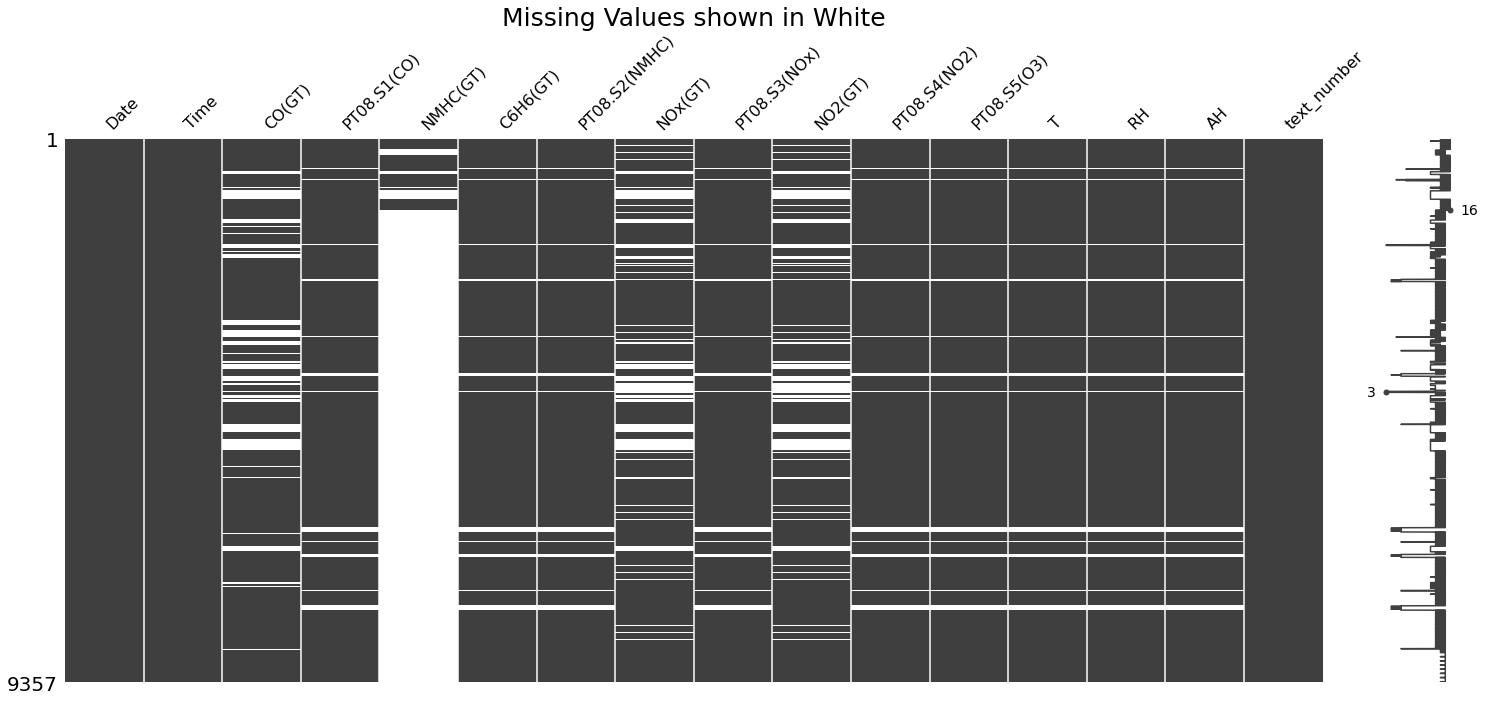

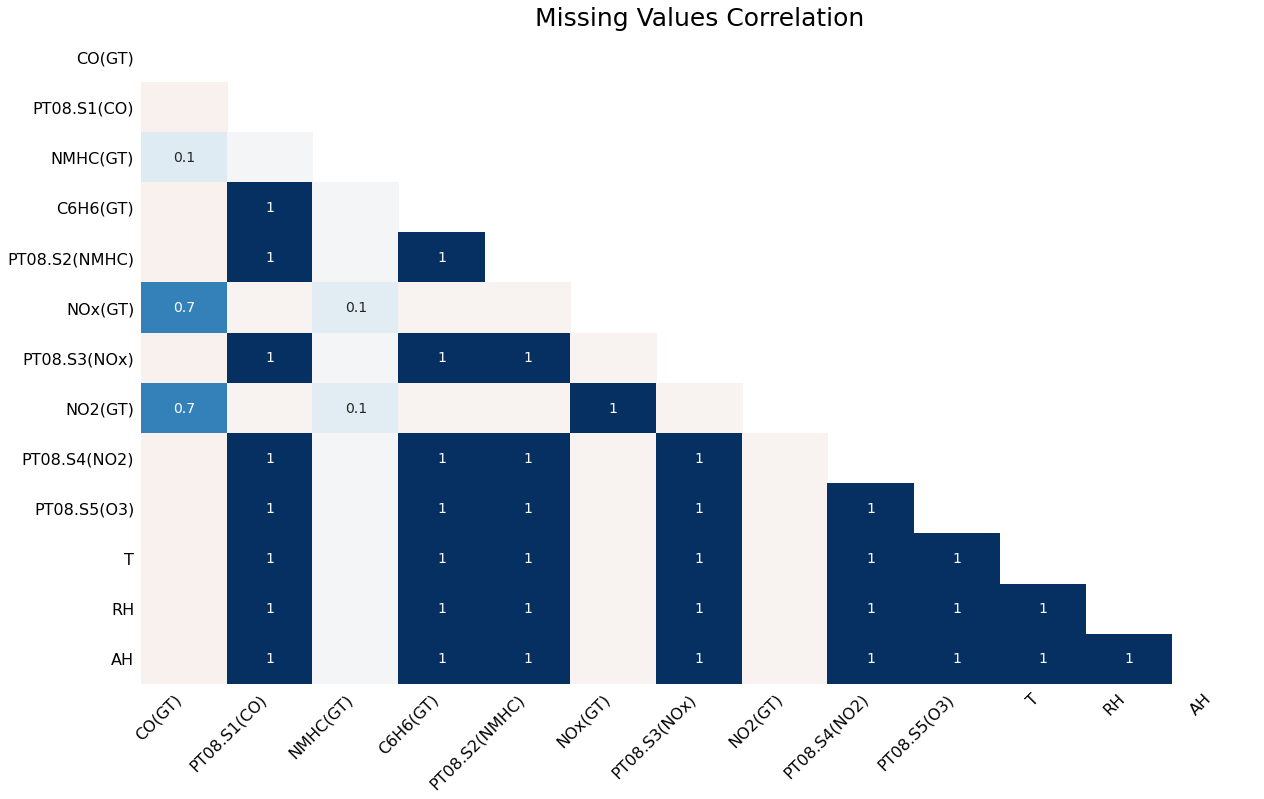

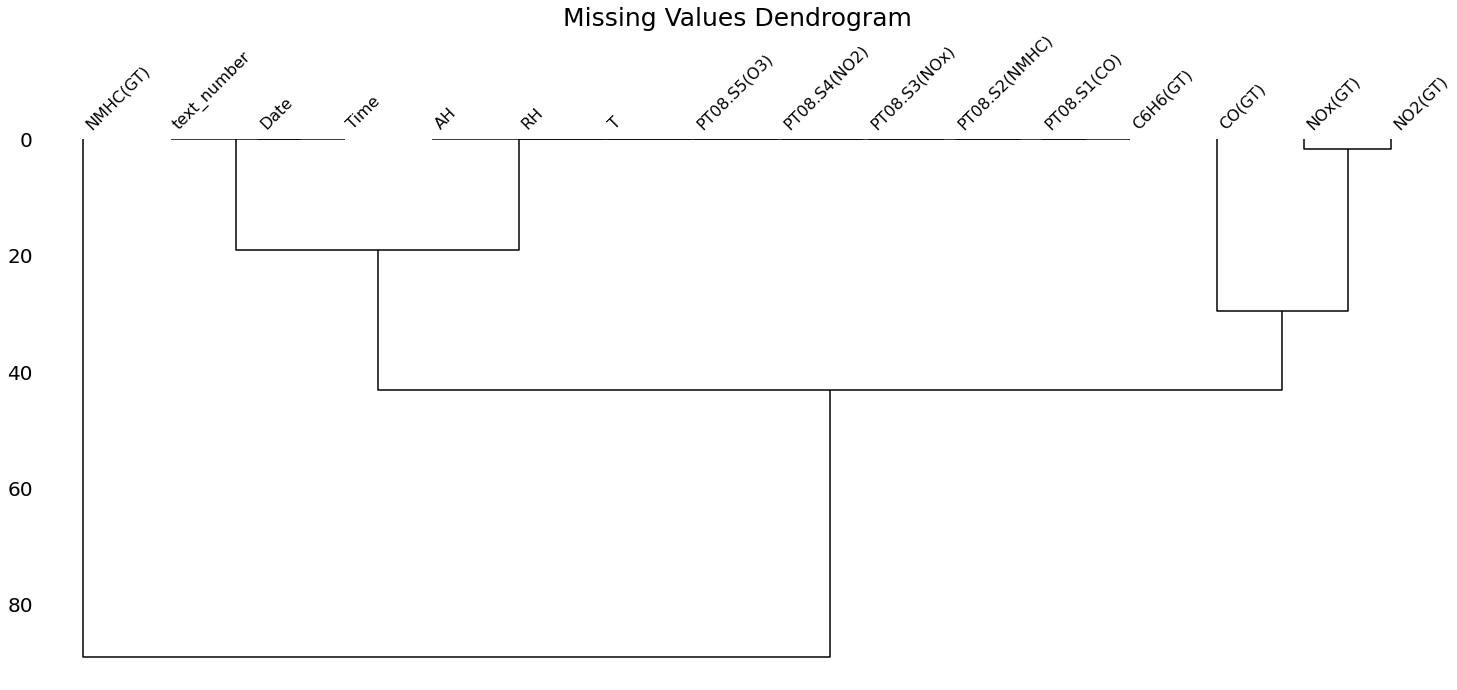

In [159]:
a.get_missings(missing_tag=-200)

In [160]:
a.handle_missings(strategy = 'mean_mode')

Count of imputed numerical values: 16701
Count of imputed categorical values: 0


In [161]:
a.get_missings()

There is no missing value, please check if the missings have been encoded with non-NAN value.
Use argument missing_tag for encoded missing values


In [162]:
a.check_data_type()

Column,Type,Cardinality,Warning,Is_datetime,String_number,Suggest
Date,object,391,None,yes,no,convert to datetime
Time,object,24,None,yes,no,convert to datetime
CO(GT),float64,97,None,no,yes,None
PT08.S1(CO),float64,1042,None,no,yes,None
NMHC(GT),float64,430,None,no,yes,None
C6H6(GT),float64,408,None,no,yes,None
PT08.S2(NMHC),float64,1246,None,no,yes,None
NOx(GT),float64,926,None,no,yes,None
PT08.S3(NOx),float64,1222,None,no,yes,None
NO2(GT),float64,284,None,no,yes,None
